In [1]:
import networkx as nx
# NOTE you will probably need to install the networkx package manually, not a standard package
import numpy as np
import time
from matplotlib import pyplot as plt
import numpy.random as ra

class SI_Simulation():
    """
    A class to simulate the SI Model.
    ===================================================
    Input: A - Network adjacency matrix (numpy array) or Networkx graph object.
           lam - Contagion parameter (S -> I rate).
           i0 - Initial infected fraction.
           prop - Propensity calculation method [ALL,FANCY], fancy only updates propensity of nodes that changed
           phi - recover parameter (I -> R rate)
           sigma - re-contagion parameter (R -> S rate)
    """

    def __init__(self, A, lam=0.1, phi=0.01, IC = [[1]], sigma = 0.001, n_path = 1, prop='ALL', t0=0, T=10):
        # NB. S = 1, I = 2, R = 3 throughout
        # Network setup.
        if type(A)==np.ndarray:
            self.A = A
        elif type(A)==nx.classes.graph.Graph:
            self.A = nx.adj_matrix(A).A
        else:
            raise BaseException("Input an adjacency matrix or networkx object only.")

        # Model Parameters.
        self.N = A.number_of_nodes()
        self.lam = lam
        self.prop = prop
        self.phi = phi
        self.n_path = n_path
        self.sigma = sigma
        self.T = T
        self.X = IC # initial condition must be given when calling the simulation class now
        self.t0 = t0
                
        # Time-keeping.
        self.t = np.array([self.t0 for n in range(self.n_path)])
        self.times = [np.array([self.t0 for n in range(self.n_path)])]
        
        # keep track of number of people in S, I and R
        temp = sum(self.X==1)
        self.S = [[temp]]
        temp = sum(self.X==2)
        self.I = [[temp]]
        temp = sum(self.X==3)
        self.R = [[temp]]
         
        # Initial propensity setup.        
        self.UpdatePropensityALL() 
        
        # Select which propensity scheme to use.
        if self.prop == 'ALL':
            self.UpdatePropensity = self.UpdatePropensityALL 
        elif self.prop == 'FANCY':
            self.UpdatePropensity = self.UpdatePropensityFANCY  
        else:
            raise BaseException("Please specify a propensity scheme [ALL,FANCY].")
        return None
        
    def UpdatePropensityALL(self, n_nodes=None):
        self.IP1 = (self.lam*self.A.dot(self.X==2))*(self.X==1)
        self.IP2 = self.phi*(self.X==2)
        self.IP3 = self.sigma*(self.X==3)
        return None
    
    def UpdatePropensityFANCY(self,n_nodes): # only update proensities of nodes that underwent changes
        self.IP1[n_nodes] = (self.lam*self.A[n_nodes].dot(self.X==2))*(self.X[n_nodes]==1)
        self.IP2[n_nodes] = self.phi*(self.X[n_nodes]==2)
        self.IP3[n_nodes] = self.sigma*(self.X[n_nodes]==3)
        return None
        
    def RunIteration(self):
        # 0. Termination.
        if self.t > self.T: # stop simulation once time interval is exceeded
            self.S = np.array(self.S, dtype=float)
            self.I = np.array(self.I, dtype=float)
            self.R = np.array(self.R, dtype=float)
            return False

        # 1. Generate random numbers r1,r2 uniformly distributed in (0,1)
        rand_list = np.random.uniform(low=0.0,high=1.0,size=(3,self.n_path))
        r1 = rand_list[0,:]
        r2 = rand_list[1,:]
        r3 = rand_list[2,:]
        
        # 2. Calculate alpha.
        self.alpha1 = np.cumsum(self.IP1,0)[-1,:]
        self.alpha2 = np.cumsum(self.IP2,0)[-1,:]
        self.alpha3 = np.cumsum(self.IP3,0)[-1,:]
        self.alpha = self.alpha1 + self.alpha2 + self.alpha3
        if self.alpha[:]==0:
            self.S = np.array(self.S, dtype=float)
            self.I = np.array(self.I, dtype=float)
            self.R = np.array(self.R, dtype=float)
            return False

        # 3. Compute the time until the next reaction takes place.
        tau = - np.divide(np.log(np.ones(self.n_path) - r1[:]), self.alpha[:])
        self.t += tau # advance time to next event/transition
        self.times.append(np.array(self.t))

        # 4. Compute which reaction takes place, i.e. which person gets infected/recovered/reinfected
        for n in range(self.n_path):
            if self.S[n][-1] != 0:
                if r2[n] <  self.alpha1[n] / self.alpha[n]: # S -> I transition
                    index = np.searchsorted(np.cumsum(self.IP1,0)[:,n],r3[n]*self.alpha1[n])
                    self.X[index%self.N,n] = 2
                    self.S[n].append(self.S[n][-1] - 1)
                    self.I[n].append(self.I[n][-1] + 1)
                    self.R[n].append(self.R[n][-1])
                elif r2[n] < (self.alpha1[n] + self.alpha2[n]) / self.alpha[n]: # I -> R transition
                    index = np.searchsorted(np.cumsum(self.IP2,0)[:,n],r3[n]*self.alpha2[n])
                    self.X[index%self.N,n] = 3
                    self.S[n].append(self.S[n][-1])
                    self.I[n].append(self.I[n][-1] - 1)
                    self.R[n].append(self.R[n][-1] + 1)
                else: # R -> S transition
                    index = np.searchsorted(np.cumsum(self.IP3,0)[:,n],r3[n]*self.alpha3[n])
                    self.X[index%self.N,n] = 1
                    self.S[n].append(self.S[n][-1] + 1)
                    self.I[n].append(self.I[n][-1])
                    self.R[n].append(self.R[n][-1] - 1)
                    
                # 6. Update propensities
                n1 = np.nonzero(self.A[index%self.N])[0] # find all indices of people connected to person who changed
                n1 = np.append(n1,index%self.N) # add the index of the person who changed to the list of neighbors
                self.UpdatePropensity(n1)
            else:
                self.S[n].append(self.S[n][-1])
                self.I[n].append(self.I[n][-1])
                self.R[n].append(self.R[n][-1])       
        return True

    def RunToConvergence(self):
        running = True
        while running:
            running = self.RunIteration()
        return None
    
# Function to plot the degree distribution of a graph
def plot_degree_dist(G): # to produce the degree node distribution of a graph
    num_nodes = len(G.nodes())
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees,5+int(np.floor(np.sqrt(num_nodes))))
    plt.show()
    
# funtion to generate group sizes based on given data/distribution
def decide_sizes(N, spectrum, p):
    array = np.array(spectrum[0])
    fluxes = np.array(spectrum[1])
    prob = fluxes/float(sum(fluxes))
    cum_prob = np.cumsum(prob)
    R = ra.uniform(0, 1, N)
    S = [int(array[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]
    for i in range(len(S)):
        check = np.where(array==S[i])
        check = check[0]
        #print(check)
        if check < len(array)-2:
            S[i]=np.random.randint(S[i], array[check+1])
            S[i]=S[i][0]
        else :
            S[i] = np.random.randint(S[i], (1+p)*S[i])
    tempS = np.cumsum(S)<N
    tempS = tempS.astype(int)
    tempS = tempS*S
    tempS = tempS[tempS != 0]
    S = np.append(tempS, np.array([N - np.sum(tempS)]), axis=0)
    return S

# function to build adjacency matrix based on group sizes
def build_adjacency(N,S,prop):
    S_con = np.zeros(shape=(N,N))
    k = 0
    for i in range(0, len(S)):
        if (S[i] == 1):
            k = k+1
        else:
            for j in range(k, k+int(S[i])-1):
                # you can put a RV here to decide whether or not household j has a child in school
                # I'd like to depend on H really though, i.e. bigger household, more chance of kids
                if np.random.uniform() < prop:
                    for ll in range(j+1, int(S[i])+k):
                        S_con[j,ll] = 1
            k = k + int(S[i])
    S_con = S_con + np.matrix.transpose(S_con) # only allocated i->j connections, transpose for j->i
    return S_con

def build_adjacency_new(N,S,prop):
    vertices = list(range(0, N)) # generate vector to hold labels of the households
    np.random.shuffle(vertices) # shuffle the labels
    S_con = np.zeros(shape=(N,N))
    k = 0
    for i in range(0, len(S)):
        if (S[i] != 1):
            for j in range(k, k + int(S[i])):
                for ll in range(k, k + int(S[i])):
                    if vertices[ll] != vertices[j]:
                        S_con[vertices[j],vertices[ll]] = 1
        k = k + int(S[i])
    # insert command here to zero out row and column j if household j doesn't work, go to school, etc.
    z = (np.random.uniform(size=N) > prop)
    z = z.nonzero()
    S_con[z] = 0
    S_con[:,z] = 0
    return S_con

def generate_contacts_poisson(lam,N):
    sequence = np.random.poisson(lam, N) # N.B the sum of this must be an even number, regenerate if not
    while np.mod(np.sum(sequence),2) != 0:
        sequence = np.random.poisson(lam, N)
    G_temp = nx.configuration_model(sequence)
    actual_degrees = [d for v, d in G_temp.degree()]
    G_temp = nx.Graph(G_temp)
    G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
    return nx.to_numpy_matrix(G_temp)


def generate_contacts_powerlaw(N,lam,ran):
    G = nx.powerlaw_cluster_graph(N, lam, ran)
    return nx.to_numpy_matrix(G)





def avg_bigger(vals,limit):
    if sum(vals)/len(vals)<limit:
        return False
    return True

def avg_smaller(vals,limit):
    if sum(vals)/len(vals)<limit:
        return True
    return False
    
def all_smaller(vals,limit):
    if limit < max(vals):
        return False
    return True

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

N=1000
0
1
2
3
4
5
6
7
7.2
7.4
7.6
7.8
8
8.2
8.4
8.6
8.8
9


ValueError: x and y must have same first dimension, but have shapes (18,) and (0,)

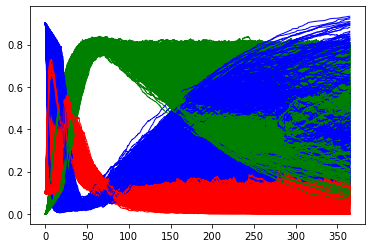

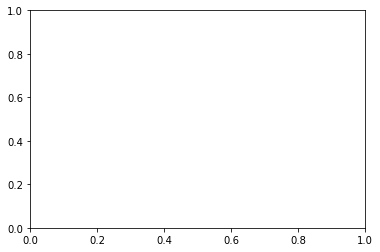

In [3]:
####### Generate a random network according to given structure/parameters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import time
import numpy.random as ra
from numpy import linalg as LA # needed to compute eigenvalues, call w1, v1 = LA.eig(S_con1), w1 has the eigenvalues
import scipy.stats as stats
import math
import random
from datetime import datetime 
from scipy import interpolate

### Set parameters (in days)

t0 = time.time()
N = 1000 # number of people
T_max = 365 # must be an integer
T = 365
#reset_time = 499 # how often should the network be reset
beta = 0.02 # infection rate, S -> I 
gamma = 0.058 # recovery rate, I -> R
nu = 0.009 # loss of immunity rate, R -> S, can be set to zero if immunity is permanent 
i0 = 0.1 # proportion of population initially infected
lockdown_impact = 0.5 # reduce average contacts by this factor
lift_lockdown = 1 # threshold of R0 to lift lockdown measures
average_contacts = 20

### Allocate people to households

F = decide_sizes(N,[[1, 2, 3, 4, 5, 6, 7],[0.2818, 0.3483, 0.1505, 0.1266, 0.058, 0.0227, 0.012]],0.3)
F_con = build_adjacency_new(N,F,1)

### Generate non-household contacts + build the network combining all contacts
lam = 18
ran = 0.1
NH_con = generate_contacts_powerlaw(N,lam,ran)
#print(NH_con)
A = NH_con + F_con
#A = (A>0)*1 # normalize the matrix, i.e. no double counting, comment out if you want weighted connections
G = nx.from_numpy_matrix(A, create_using=None) # create the network/graph object for the dynamics

### Run the SIR model on the generated network
n_path = 1 # number of paths to be simulated
prop='FANCY' # selects the algorithm for updating nodes
print(f'N={N}')

### Generate an initial condition for the simulation

I = [[int(i0*N)] for n in range(n_path)]
S = [[N-I[n][0]] for n in range(n_path)]
R = [[N-I[n][0]-S[n][0]] for n in range(n_path)]
X = np.array([1]*S[0][0] + [2]*I[0][0] + [3]*R[0][0]).reshape((N,1))
X = np.transpose(np.tile(X, (n_path,1,1)),(1,0,2)).reshape((N,n_path))
np.random.shuffle(X[:,:])

### Run the model

### evolve the model forward epoch by epoch, redrawing connections as necessary

I_totals = []
upper_errors = []
lower_errors = []
lockdown_impacts = []
stdev = []

#current_epoch = reset_time

# initial run before the first network reset
model = SI_Simulation(G, lam=beta, phi=gamma, n_path=n_path, IC = X, prop = prop, sigma = nu, t0 = 0.0, T = T_max)
model.RunToConvergence()
times = model.times
S_data = model.S
I_data = model.I
R_data = model.R

d = 7

M = 10
a=[0,1,2,3,4,5,6,7,7.2,7.4,7.6,7.8,8,8.2,8.4,8.6,8.8,9]
SIR_uniform_data = []
peak_infections_data= []

for jj in a:
    # redraw network connections here
    print(jj)
    lockdown_impact = jj/M
    lockdown_impacts = np.append(lockdown_impacts,lockdown_impact)
    lam = 18
    ran = 0.1    
    summ = 0
    I_total_array=[]
    sum_I_total_array = 0
    R0_data = []
    peak_infections = []
    z = 50
    for j in range(0,z):
        TT=[]
        SS=[]
        II=[]
        RR=[]
        f1=[]
        f2=[]
        f3=[]
        times = np.append(times,model.times)
        lockdown_times = np.array([])
        relaxation_times = np.array([])
        NH_con = generate_contacts_powerlaw(N,lam,ran)
        A = NH_con + F_con
        G = nx.from_numpy_matrix(A, create_using=None)
        # run next epoch of the model
        I = [[int(i0*N)] for n in range(n_path)]
        S = [[N-I[n][0]] for n in range(n_path)]
        R = [[N-I[n][0] - S[n][0]] for n in range(n_path)]
        X = np.array([1]*S[0][0] + [2]*I[0][0] + [3]*R[0][0]).reshape((N,1))
        X = np.transpose(np.tile(X, (n_path,1,1)),(1,0,2)).reshape((N,n_path))
        np.random.shuffle(X[:,:])
        T_current = 0
        times = []
        S_data = []
        I_data = []
        R_data = []
        days_in_lockdown = 0
        while T_current < T_max:
            if T_current == 0:
                model = SI_Simulation(G, lam=beta, phi=gamma, n_path=n_path, IC=X, prop=prop, sigma=nu, t0=0.0, T = T_current+1)
                model.RunToConvergence()   
            else:
                model = SI_Simulation(G, lam=beta, phi=gamma, n_path=n_path, IC=model.X, prop=prop, sigma=nu, t0=model.times[-1], T = T_current+1)
                model.RunToConvergence()
        #print(model.I)
        #Use the diff of I_data to calculate the sum of infected people
            times = np.append(times,model.times)
            S_data = np.append(S_data,model.S)
            I_data = np.append(I_data,model.I)
            R_data = np.append(R_data,model.R)
            temp_infections = np.diff(model.I[0][:,0]) > 0
            if model.I[0,0][0]==0:
                R0=0
            else:
                R0 = (np.sum(temp_infections.astype(float))/model.I[0,0][0])/gamma
            #print(R0)
            R0_data = np.append(R0_data,R0)
            if T_current > d:
                if R0 > 1: # als try: don't lockdown unless R0 above 1 for d days 
                    lam = int((1-lockdown_impact)*average_contacts)
                    lockdown_times = np.append(lockdown_times,np.max(times))
                    NH_con = generate_contacts_powerlaw(N,lam,ran)
                    A = NH_con + F_con
                    G = nx.from_numpy_matrix(A, create_using=None)
                    days_in_lockdown = days_in_lockdown + 1
                elif all_smaller(R0_data[max(T_current-d,0):T_current],lift_lockdown) == True:
                    lam = int(average_contacts) # relax the lockdown
                    NH_con = generate_contacts_powerlaw(N,lam,ran)
                    A = NH_con + F_con
                    G = nx.from_numpy_matrix(A, create_using=None)
            T_current = T_current + 1
            
        uniform_time = np.arange(0.0, T, 0.1)
        TT = np.concatenate( (TT, times) )
        SS = np.concatenate( (SS, S_data))
        II = np.concatenate( (II, I_data) )
        RR = np.concatenate( (RR, R_data) )

        f1 = interpolate.interp1d(TT, SS)
        S = f1(uniform_time) # get S on the uniform time grid (approximately)
        f2 = interpolate.interp1d(TT, II) # create the interpolating function
        I = f2(uniform_time) # get I on the uniform time grid (approximately)
        f3 = interpolate.interp1d(TT, RR) # create the interpolating function
        R = f3(uniform_time) 
        # plot the raw path from each loop for comparison purposes
        plt.plot(uniform_time,S/N, 'b-', linewidth = 1);
        plt.plot(uniform_time,I/N, 'r-', linewidth = 1);
        plt.plot(uniform_time,R/N, 'g-', linewidth = 1);

        #### new code for peak analysis
        II_temp = II.tolist()
        II_temp = np.concatenate((II_temp, I_data))
        II_temp = II_temp.tolist()
        peak_infections = np.append(peak_infections, np.max(II_temp) )
        SIR_uniform_data.append(np.array((S,I,R)))


        v = np.diff(I_data) 
        #print(v)
        I_total_list = [ele for ele in v if ele > 0] 
        I_total = np.sum(I_total_list)
        I_total_array = np.append(I_total_array,I_total)
        #print('Total number of infections: %3.0f people' % (I_total))    
        #print('Peak infections: %3.0f people' % (Imax))    
        #print('Total time in lockdown: %3.0f days' % (days_in_lockdown))
        
    #I_totals = np.append(I_totals,np.mean(I_total_array)) 
    #upper_errors = np.append(upper_errors,np.percentile(I_total_array, 95, axis = 0))
    #lower_errors = np.append(lower_errors,np.percentile(I_total_array, 5, axis = 0))
    #stdev = np.append(stdev,np.std(I_total_array))
    #print('Model runtime so far is %3.2f seconds' % (time.time() - t0))
    avg = np.mean(peak_infections)
    #print(avg)
    peak_infections_data.append(avg)
    upper_errors = np.append(upper_errors,np.percentile(peak_infections, 95, axis = 0))
    lower_errors = np.append(lower_errors,np.percentile(peak_infections, 5, axis = 0))
    stdev = np.append(stdev,np.std(I_total_array))
    
fig1 = plt.figure()
plt.plot(lockdown_impacts, I_totals, color = 'b', marker='o', linewidth = 2)
plt.fill_between(lockdown_impacts, lower_errors, upper_errors,
                 color='b', alpha=0.2)
#plt.scatter(lockdown_impacts,I_totals,label="0 Cu", edgecolor='blue', linewidth=2)
#ax.errorbar(lockdown_impacts,I_totals,yerr=[upper_errors,lower_errors]')
plt.xlabel('Proportion of contacts cut')
plt.ylabel('Total infections')

fig2 = plt.figure()
plt.plot(lockdown_impacts, peak_infections_data,color = 'b', marker='o', linewidth = 2)
plt.fill_between(lockdown_impacts, lower_errors, upper_errors,
                 color='b', alpha=0.2)
plt.xlabel('Proportion of contacts cut')
plt.ylabel('Peak infections')

print('Total model runtime was %3.2f seconds' % (time.time() - t0))

In [ ]:
np.std(I_total_array)

In [4]:
print(stdev)

[ 47.53508599  32.57068621  50.99899607  49.12972624  56.87635713
  51.67854874  47.80000418  65.95946937  95.90508016  77.18204195
 195.8124613  223.44441904 121.3296732  158.41760508 148.63525827
 471.25616643 127.44306337 436.44178031 509.40208912]


In [11]:
print(lockdown_impacts)

[0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9 ]


In [10]:
print(peak_infections_data)

[724.26, 703.6, 683.62, 656.42, 626.48, 588.82, 544.3, 518.4, 617.98, 496.42, 483.04, 485.28, 474.94, 473.86, 472.12, 498.36, 495.52, 525.08]


In [8]:
print(lower_errors)

[702.45 682.45 652.35 633.45 594.45 559.35 515.7  474.8  449.   450.35
 434.6  448.45 420.2  418.35 423.8  434.8  446.35 486.7 ]


In [9]:
print(upper_errors)

[749.85 726.   708.   677.65 651.55 624.1  571.   550.1  741.65 536.75
 521.2  530.85 526.2  532.05 520.85 557.5  534.1  558.65]
